In [1]:
import pandas as pd
from datasets import load_dataset

data = load_dataset("csv", data_files="../input/real-and-synthetic-megablunders/megablunders.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
import random
import numpy as np
import torch
from transformers import set_seed

SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set PyTorch seed
torch.manual_seed(SEED)

# Set seed for CUDA
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior in PyTorch (optional, but helpful)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set Hugging Face Transformers seed (Trainer-related randomness)
set_seed(SEED)

2025-06-04 23:58:17.144244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749081497.374287      26 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749081497.437114      26 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(data.column_names)

{'train': ['text', 'label']}


In [4]:
dataset = data["train"]  # 'train' is the default split name when loading a CSV

Available columns: ['text', 'label']
Example row: {'text': 'By dropping a game to the pathetic Tampa Bay Devil Rays, we may be on the verge of another Red Sox collapse.', 'label': 'DM'}
Class Distribution:
DM: 22
FRAG: 20
PR: 22
AGREE: 16
PAR: 22
CASE: 19
ROS: 22
NONE: 22
MM: 20


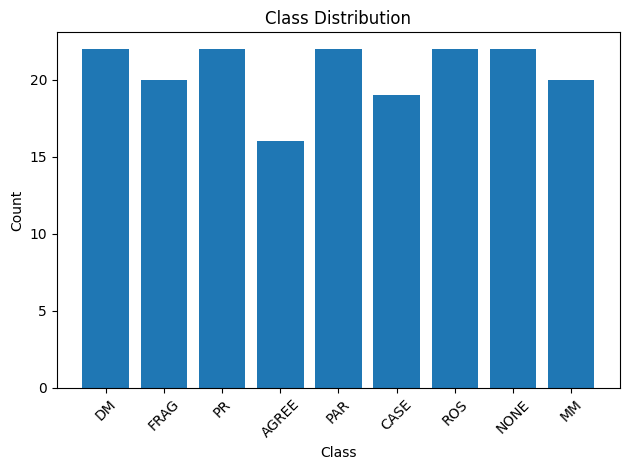

In [5]:
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

# Load dataset (example: already loaded as `dataset`)
# dataset = load_dataset("your_dataset")["train"]  # uncomment if needed

print("Available columns:", dataset.column_names)
print("Example row:", dataset[0])

label_column = "label"  # change if needed
labels = dataset[label_column] 

# Count labels
label_counts = Counter(labels)

# Map integer labels to names if available
if hasattr(dataset.features[label_column], "names"):
    label_names = dataset.features[label_column].names
    label_counts_named = {label_names[k]: v for k, v in label_counts.items()}
else:
    label_counts_named = label_counts

# Print class distribution
print("Class Distribution:")
for label, count in label_counts_named.items():
    print(f"{label}: {count}")

# Plot it
plt.bar(label_counts_named.keys(), label_counts_named.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
data = load_dataset("csv", data_files="../input/real-and-synthetic-megablunders/megablunders.csv")

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Define label list based on your grammar error categories
label_list = ["AGREE", "DM", "MM", "ROS", "PR", "PAR", "FRAG", "CASE", "NONE"]
label_to_id = {label: i for i, label in enumerate(label_list)}

# Function to convert string labels to numerical indices
def convert_labels(examples):
    # Make sure the column name matches your dataset's label column
    # If your label column is not named "label", change it accordingly
    examples["label"] = [label_to_id[label] for label in examples["label"]]
    return examples

# Apply the conversion to your dataset
data = data.map(convert_labels, batched=True)

# Verify the conversion worked
print(f"Converted labels: {data['train']['label'][:5]}")

Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Converted labels: [1, 6, 4, 0, 5]


In [9]:
data['train'][:5]

{'text': ['By dropping a game to the pathetic Tampa Bay Devil Rays, we may be on the verge of another Red Sox collapse.',
  'Although, if history is any indication, the tease could still go on for several weeks.',
  'The Sox almost never go down uneventfully, which is the most frustrating thing for their legion of fans.',
  'Because of the accumulated bad karma that hangs over the franchise, the skill of the players in any given year seem to be irrelevant to the outcome.',
  'The team not only has squandered huge leads but also it has come roaring from behind only to fall short.to fall short.'],
 'label': [1, 6, 4, 0, 5]}

In [10]:
def tokenize(examples):
   return tokenizer(examples["text"], padding="max_length", truncation=True)

data = data.map(tokenize, batched=True)

Map:   0%|          | 0/185 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=9)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# for name, param in model.named_parameters():
#     if name.startswith("bert.encoder.layer"):
#         layer_num = int(name.split('.')[3])
#         if layer_num < 8:  # freeze layers 0-7
#             param.requires_grad = True
#     elif "classifier" not in name:
#         param.requires_grad = True  # or False to freeze


In [13]:
import evaluate
import numpy as np

acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = prec_metric.compute(
        predictions=preds, references=labels, average="macro", zero_division=0,
    )["precision"]

    return {"accuracy": acc, "precision": prec}


In [14]:
from transformers import TrainingArguments

trainingArguments = TrainingArguments(
    output_dir="megablunders",
    save_total_limit=2,
    warmup_steps=20,
    num_train_epochs=200,
    learning_rate=5e-6,
    eval_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    logging_steps=10, 
    logging_strategy="steps",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_precision",
    greater_is_better=True,
)

In [15]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# from transformers import Trainer
from transformers import Trainer
from datasets import DatasetDict

# Split the training data into train and test sets
train_test_split = data["train"].train_test_split(test_size=0.2, seed=42)
data = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

trainer = Trainer(
    model=model,
    args=trainingArguments,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,2.226800,2.381837,0.108108,0.013514
2,2.133800,2.226068,0.135135,0.111111
3,2.119700,2.262558,0.135135,0.111607
4,2.071700,2.106886,0.270270,0.202146
5,1.997100,2.044147,0.189189,0.069805
6,1.882600,2.047607,0.216216,0.194444
7,1.830600,1.959539,0.270270,0.130208
8,1.786100,1.984591,0.270270,0.207702
9,1.719900,1.861828,0.378378,0.310417
10,1.710900,1.947139,0.297297,0.289299


TrainOutput(global_step=3800, training_loss=0.295465521974195, metrics={'train_runtime': 2837.2126, 'train_samples_per_second': 10.433, 'train_steps_per_second': 1.339, 'total_flos': 7788576721305600.0, 'train_loss': 0.295465521974195, 'epoch': 200.0})

In [17]:
import torch
from transformers import BertTokenizer

# Prepare sentence list
test_examples = [
    "Because she was tired.",  # Fragment
    "Walking down the street, the dog was barking.",  # Dangling modifier
    "I only ate pizza yesterday.",  # Misplaced modifier
    "Everyone should bring their own lunch.",  # Pronoun reference
    "She likes swimming, running, and to bike.",  # Parallelism
    "Him and I went to the store.",  # Case error
    "The team are playing well.",  # Subject-verb agreement
    "Neither the mountain of unread submissions nor the myriad footnotes buried in the appendix have been reviewed by the editorial team despite multiple reminders circulated through internal memos and follow-up emails, each increasingly terse and exasperate"
]

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize (note: passing list directly!)
inputs = tokenizer(test_examples, return_tensors="pt", truncation=True, padding=True)

# Get the model device
device = next(model.parameters()).device

# Move inputs to model's device
inputs = {key: val.to(device) for key, val in inputs.items()}

# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_ids = logits.argmax(dim=1).tolist()

# Label names (adjust if your labels differ)
label_list = ["AGREE", "DM", "MM", "ROS", "PR", "PAR", "FRAG", "CASE", "NONE"]

# Display predictions
for sentence, class_id in zip(test_examples, predicted_class_ids):
    print(f"{sentence} => {label_list[class_id]}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Because she was tired. => FRAG
Walking down the street, the dog was barking. => DM
I only ate pizza yesterday. => FRAG
Everyone should bring their own lunch. => DM
She likes swimming, running, and to bike. => MM
Him and I went to the store. => CASE
The team are playing well. => CASE
Neither the mountain of unread submissions nor the myriad footnotes buried in the appendix have been reviewed by the editorial team despite multiple reminders circulated through internal memos and follow-up emails, each increasingly terse and exasperate => CASE


In [18]:
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix

hard_sentences = [
    "While the extent of this improvement that can be attributed to Trotsky is difficult to discern, especially when one considers that some improvement could be attributed to economic recovery from the Great War and the Russian Civil War as well as various other NEP policies because Trotsky created the unanimously approved four-stage plan, which guided economic policies during the NEP-era, and he advocated heavily for the electrification of Russia prior to his lackluster time as a director of the ETO, a significant portion of the improvement in power generation can be credited to Trotsky.",
    "The array of volatile variables, along with the coefficients derived from inconsistent models, suggest the conclusion remains unsubstantiated because neither the assumptions nor the results correspond consistently with empirical observations, which trouble the most experienced statisticians.",
    "Showcasing a rare Ming Dynasty manuscript—known for its thin brushstrokes and mulberry-bark paper fibers—the curator presented the masterpiece to a group of tourists who had been kept in airtight chambers for preservation.",
    "A carbon tax would generate significant funds amounting to nearly 125 million dollars; with the money generated from a carbon tax, the government should invest in social services: 10% of it should go to low-income households and the rest should go to the most pressing issues at the time of the carbon tax, which are currently the government deficit and a potential default.",
    "There is a common belief that pirates killed whoever they saw, but this belief is false.",
    "Leo believes that the average human is much more feeble than I.",
    "Once the memoir was released, with its fragmented prose and deliberately inconsistent chronology, it became clear that the audience would not respond uniformly, a response which frustrated reviewers who struggled to determine its purpose, they wondered whether it was meant to alienate.",
    "If I was in Ms. Tan's class and in your situation, I would ask the academic dean, who is very harsh, and Ms. Tan for an extension on the history paper.",
    "The pot boiling from the flames, the special potion was made by the evil witch despite the pot’s near bursting.",
    "Neither the mountain of unread submissions nor the myriad footnotes buried in the appendix have been reviewed by the editorial team despite multiple reminders circulated through internal memos and follow-up emails, each increasingly terse and exasperated.",
    "The violinist performed the final movement, wearing a sequined jacket once owned by a Hungarian virtuoso, to a jury of professors who had studied under Bartók and whose applause was hesitant.",
    "I know that you knew that I'm as wise as him."
]

hard_errors_correct = [
    "NONE",
    "AGREE",
    "MM",
    "PR",
    "CASE",
    "CASE",
    "NONE",
    "AGREE",
    "NONE",
    "AGREE",
    "MM",
    "CASE"
]

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
inputs = tokenizer(hard_sentences, return_tensors="pt", truncation=True, padding=True)

# Get the model device
device = next(model.parameters()).device

# Move inputs to model's device
inputs = {key: val.to(device) for key, val in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_ids = logits.argmax(dim=1).tolist()

# Convert predictions to labels
predicted_labels = [label_list[i] for i in predicted_ids]

# Calculate accuracy
correct = sum(p == g for p, g in zip(predicted_labels, hard_errors_correct))
accuracy = correct / len(hard_errors_correct)

# Display predictions
results = list(zip(hard_sentences, predicted_labels, hard_errors_correct))
print(tabulate(results, headers=["Sentence", "Predicted", "Actual"], tablefmt="grid"))

# Classification report
print("\nClassification Report:")
print(classification_report(hard_errors_correct, predicted_labels, labels=label_list))

print(f"\nAccuracy on hard set: {accuracy:.2%}")

print("\nConfusion Matrix:")
print(confusion_matrix(hard_errors_correct, predicted_labels, labels=label_list))

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+----------+
| Sentence                                                                                                                                                                                                                                                                                                                                                                                 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.